## Batch correction experiments

We were curious how much non-linear signal exists in the data for the mutation prediction problem. To analyze this, we use [limma](https://bioconductor.org/packages/release/bioc/html/limma.html) to perform linear batch correction, using mutation status in the target gene as the batch indicator. This effectively removes all linear predictive signal from the data.

We ran this experiment for the same six genes we used in the multi-omics experiments: TP53, KRAS, EGFR, IDH1, SETD2, and PIK3CA. We have previously observed that all of these genes contain considerable predictive signal.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'batch_correction')

# which gene to plot
plot_genes = ['TP53', 'KRAS', 'EGFR', 'IDH1', 'SETD2', 'PIK3CA']

# how many features to plot, 1000 or 5000
plot_feats = 1000

In [3]:
def load_single_model(results_dir):
    results_df = pd.DataFrame()
    for results_file in results_dir.iterdir():
        if not results_file.is_file(): continue
        results_filename = str(results_file.stem)
        if results_filename[0] == '.': continue
        if ('classify' not in results_filename or 
            'metrics' not in results_filename): continue
        id_results_df = pd.read_csv(results_file, sep='\t')
        results_df = pd.concat((results_df, id_results_df))
    return results_df
    
def load_all_models(base_results_dir, genes, num_feats):
    models = ['linear', 'nonlinear', 'linear_bc', 'nonlinear_bc']
    results_df = pd.DataFrame()
    for gene in genes:
        for model in models:
            results_dir = Path(base_results_dir,
                               '{}_{}'.format(model, num_feats),
                               'gene',
                               gene)
            try:
                model_results_df = load_single_model(results_dir)
                model_results_df['model'] = model
                model_results_df['num_feats'] = num_feats
            except FileNotFoundError:
                model_results_df = pd.DataFrame()
            results_df = pd.concat((results_df, model_results_df))
    return results_df

In [4]:
results_df = load_all_models(base_results_dir, plot_genes, plot_feats)
print(results_df.shape)
results_df.head()

(1152, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.75294,0.72823,TP53,expression,shuffled,42,train,0,linear,1000
1,0.73665,0.70309,TP53,expression,shuffled,42,test,0,linear,1000
2,0.62456,0.57947,TP53,expression,shuffled,42,cv,0,linear,1000
3,0.75221,0.72712,TP53,expression,shuffled,42,train,1,linear,1000
4,0.70829,0.68295,TP53,expression,shuffled,42,test,1,linear,1000


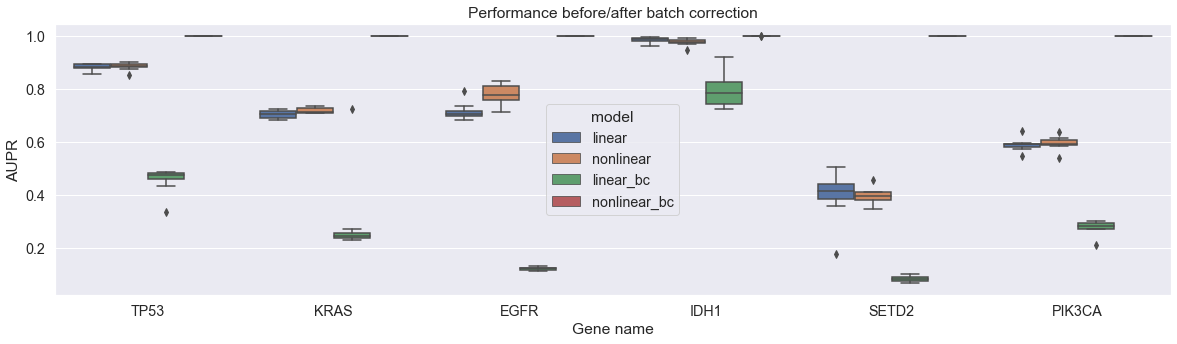

In [5]:
plot_df = results_df[
    (results_df.signal == 'signal') &
    (results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (20, 5)})
    sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR')
    plt.title('Performance before/after batch correction')

In [6]:
cmp_results_df = pd.DataFrame()
for model in results_df.model.unique():
    cmp_model_results_df = au.compare_control_ind(results_df[results_df.model == model],
                                                  identifier='identifier',
                                                  metric='aupr',
                                                  verbose=True)
    cmp_model_results_df['model'] = model
    cmp_results_df = pd.concat((cmp_results_df, cmp_model_results_df))
cmp_results_df.head()

,identifier,seed,fold,delta_aupr,model
0,EGFR,42,0,0.53390,linear
1,EGFR,42,1,0.50484,linear
2,EGFR,42,2,0.62369,linear
3,EGFR,42,3,0.55159,linear
4,EGFR,1,0,0.51877,linear


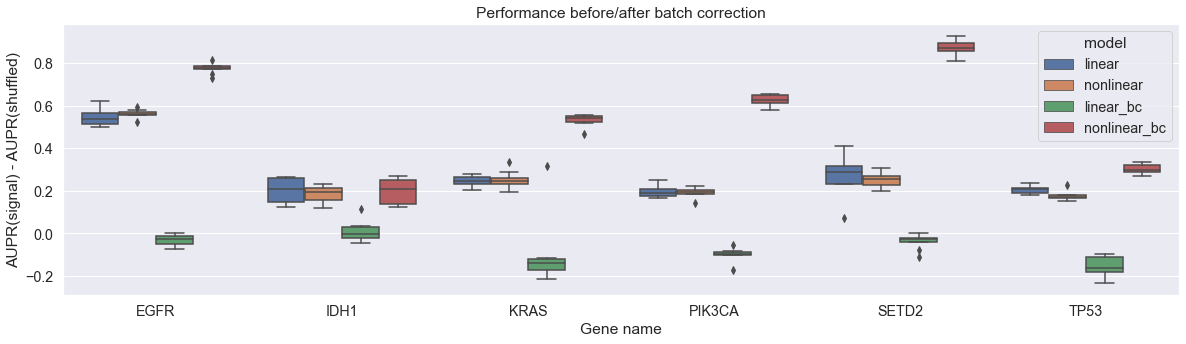

In [7]:
sns.set({'figure.figsize': (20, 5)})

with sns.plotting_context('notebook', font_scale=1.3):
    sns.boxplot(data=cmp_results_df, x='identifier', y='delta_aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR(signal) - AUPR(shuffled)')
    plt.title('Performance before/after batch correction')

From these plots, we can see that the nonlinear model (LightGBM, a gradient boosted trees classification model) appears to perform essentially perfectly after batch correction, although it provides no/little performance gain before batch correction. Not sure why this is the case.

As expected, we see that after batch correction, the linear models have equal or worse performance to the models with permuted labels. This suggests that limma is correctly removing linear signal relevant to the labels.

### Feature importance analysis

We use [information gain](https://github.com/Microsoft/LightGBM/issues/1842) to measure feature importance from LightGBM, and regression coefficients to measure feature importance for the linear model.

In [8]:
# look at feature importances/coefficients
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'batch_correction_feats')

gene = 'TP53'
num_feats = 1000
seed = 42
fold = 0

models = ['linear', 'nonlinear', 'linear_bc', 'nonlinear_bc']
all_coefs_df = pd.DataFrame()
for model in models:
    results_dir = Path(base_results_dir,
                       '{}_{}'.format(model, num_feats),
                       'gene',
                       gene)
    coefs_file = '{}_expression_signal_classify_s{}_coefficients.tsv.gz'.format(
        gene, seed)
    coefs_file = results_dir / coefs_file

    coefs_df = pd.read_csv(coefs_file, sep='\t')
    coefs_df = coefs_df.loc[coefs_df.fold == fold, :].copy()
    coefs_df['model'] = model
    coefs_df['is_covariate'] = ~coefs_df['feature'].str.isdigit()
    all_coefs_df = pd.concat((all_coefs_df, coefs_df))
    
print(all_coefs_df.shape)
print(all_coefs_df.model.unique())
all_coefs_df.head()

(4088, 10)
['linear' 'nonlinear' 'linear_bc' 'nonlinear_bc']


,feature,weight,abs,signal,seed,identifier,training_data,fold,model,is_covariate
0,1026,-0.61411,0.61411,signal,42,TP53,expression,0,linear,False
1,CESC,-0.48475,0.48475,signal,42,TP53,expression,0,linear,True
2,6146,0.30845,0.30845,signal,42,TP53,expression,0,linear,False
3,log10_mut,0.30460,0.30460,signal,42,TP53,expression,0,linear,True
4,6125,0.29343,0.29343,signal,42,TP53,expression,0,linear,False


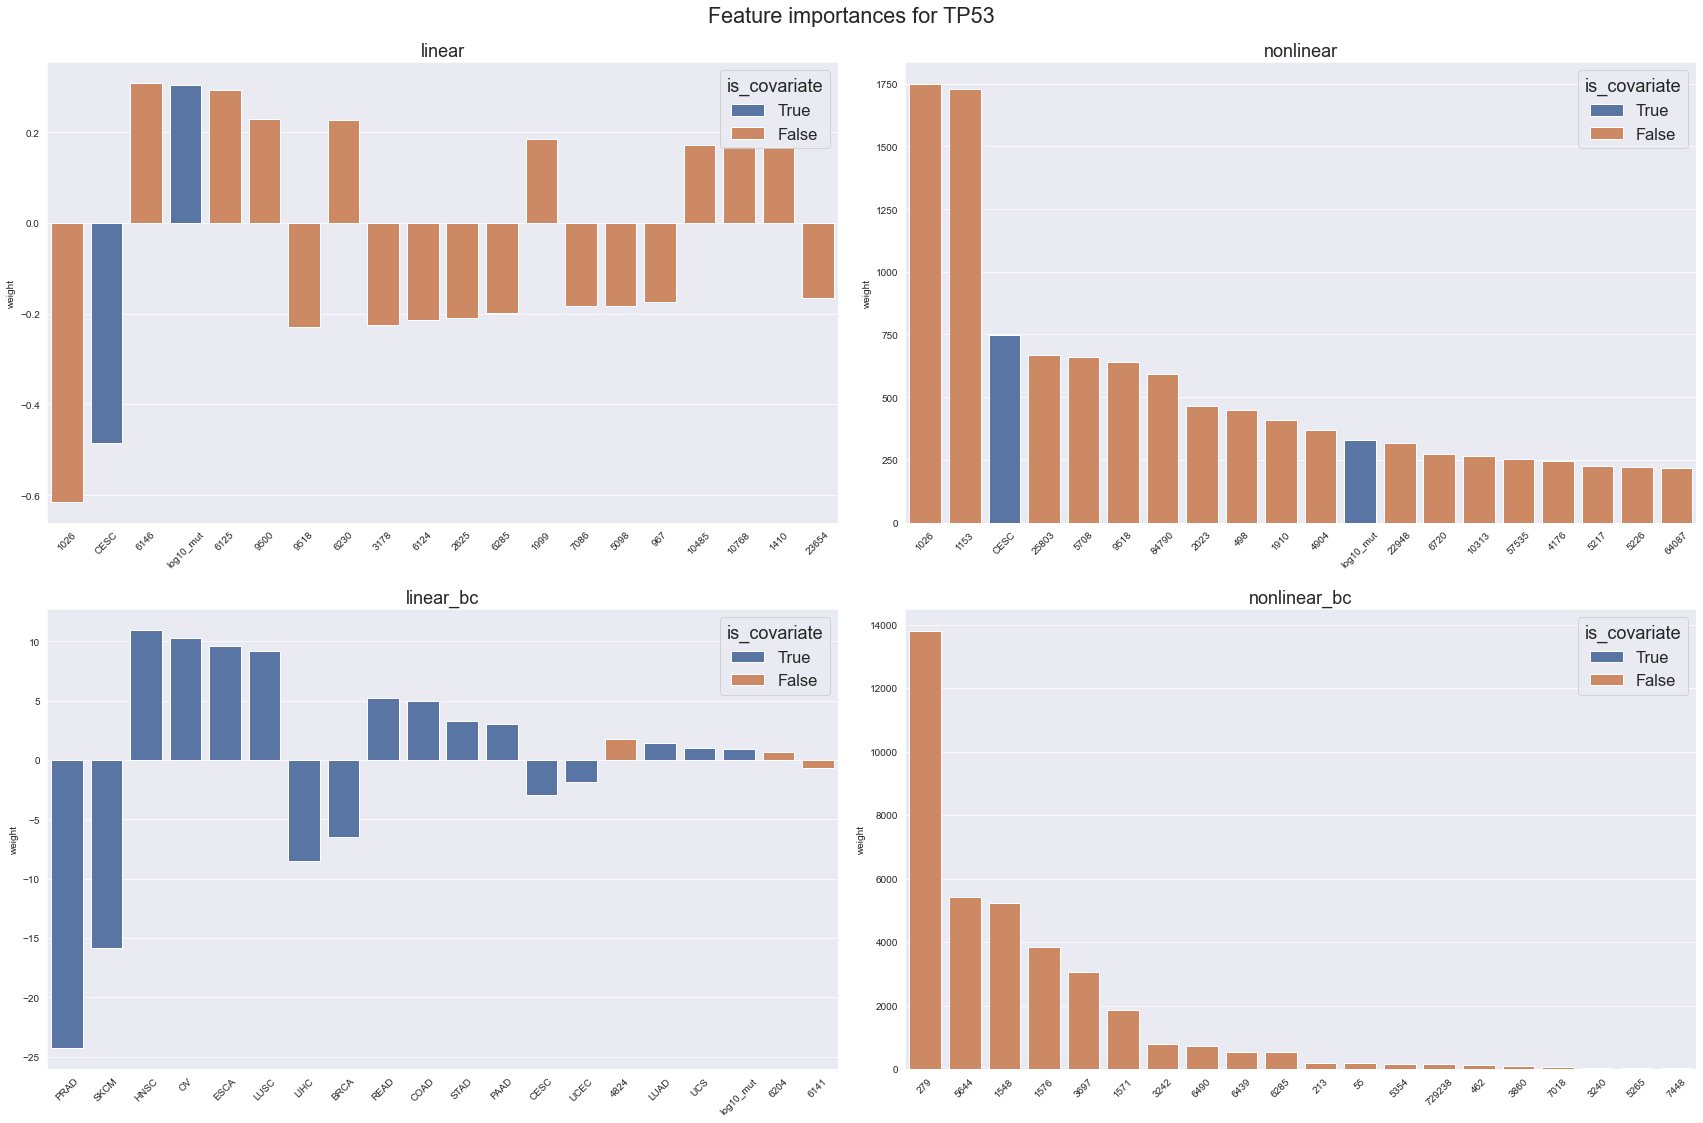

In [9]:
sns.set({'figure.figsize': (24, 16)})
fig, axarr = plt.subplots(2, 2)

with sns.plotting_context('notebook', font_scale=1.5):
    for ix, model in enumerate(models):
        ax = axarr[ix // 2, ix % 2]
        plot_df = (all_coefs_df
            [(all_coefs_df.model == model) &
             (all_coefs_df.signal == 'signal')]
            .sort_values(by='abs', ascending=False)
            .iloc[:20, :]
            .reset_index()
        )
        sns.barplot(data=plot_df, x=plot_df.index, y=plot_df.weight,
                    dodge=False, hue='is_covariate', hue_order=[True, False],
                    ax=ax)
        ax.legend(loc='upper right', title='is_covariate')
        ax.set_title(model)
        ax.set_xticklabels(plot_df.feature)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    plt.suptitle('Feature importances for {}'.format(gene))
    plt.tight_layout()

As far as I can tell, there doesn't seem to be any strong trends here. It does look like the non-linear model uses very few features after batch correction to make its perfect predictions, but there's no obvious pattern to what features these are - they seem to be gene features (not cancer type covariates), and they seem to differ between labels/target genes.

### Cancer type batch correction analysis

As a control, we ran the same experiments, using cancer type as a batch correction indicator rather than the label. We're still predicting the mutation status label. We didn't expect to see the same perfect prediction after batch correcting for cancer type (if that happens, something is clearly broken).

In [10]:
model_pairs = [('linear', 'linear_bc'), ('nonlinear', 'nonlinear_bc')]
for pair in model_pairs:
    df1 = (
        all_coefs_df[(all_coefs_df.model == pair[0]) &
                     (all_coefs_df.signal == 'signal') &
                     (all_coefs_df.seed == seed) &
                     (all_coefs_df.fold == fold)]
          .drop(columns=['signal', 'seed', 'fold', 'identifier', 'training_data'])
    )
    df2 = (
        all_coefs_df[(all_coefs_df.model == pair[1]) &
                     (all_coefs_df.signal == 'signal') &
                     (all_coefs_df.seed == seed) &
                     (all_coefs_df.fold == fold)]
          .drop(columns=['signal', 'seed', 'fold', 'identifier', 'training_data'])
          .sort_values(by='abs', ascending=False)
    )
    merged_df = pd.concat((df2, df1))
    top_features = df2.feature[:35]
    merged_df = merged_df[merged_df.feature.isin(top_features)]
print(merged_df.shape)
merged_df.sort_values(by='feature').head()

(70, 5)


,feature,weight,abs,model,is_covariate
445,1,10.81400,10.81400,nonlinear,False
32,1,0.14715,0.14715,nonlinear_bc,False
2,1548,5244.80000,5244.80000,nonlinear_bc,False
531,1548,8.31540,8.31540,nonlinear,False
5,1571,1849.90000,1849.90000,nonlinear_bc,False


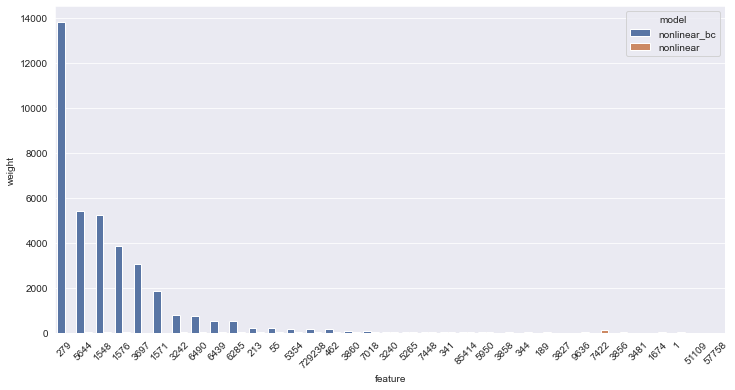

In [11]:
sns.set({'figure.figsize': (12, 6)})
sns.barplot(data=merged_df, x='feature', y='weight', hue='model')
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(45)

In [12]:
# set results directory
cancer_type_base_results_dir = Path(cfg.results_dirs['mutation'],
                                    'bc_cancer_type')

In [13]:
cancer_type_results_df = load_all_models(cancer_type_base_results_dir, plot_genes, plot_feats)
print(cancer_type_results_df.shape)
cancer_type_results_df.head()

(1056, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.75294,0.72823,TP53,expression,shuffled,42.0,train,0.0,linear,1000
1,0.73665,0.70309,TP53,expression,shuffled,42.0,test,0.0,linear,1000
2,0.62456,0.57947,TP53,expression,shuffled,42.0,cv,0.0,linear,1000
3,0.75221,0.72712,TP53,expression,shuffled,42.0,train,1.0,linear,1000
4,0.70829,0.68295,TP53,expression,shuffled,42.0,test,1.0,linear,1000


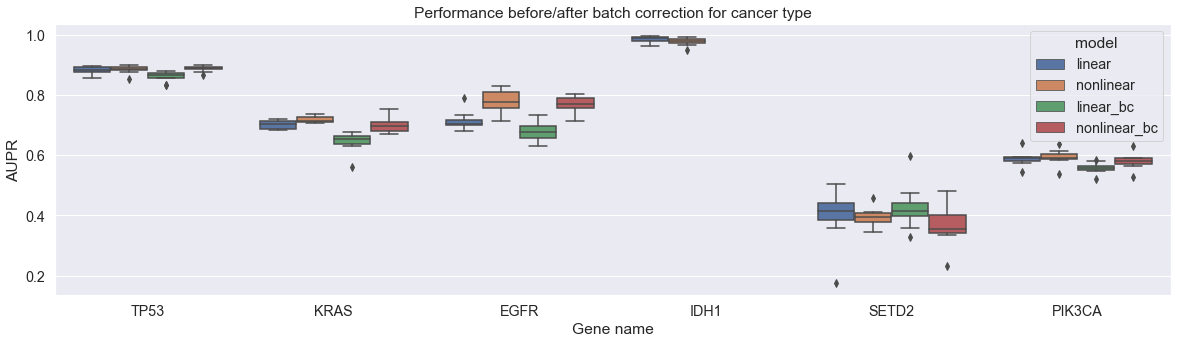

In [14]:
plot_df = cancer_type_results_df[
    (cancer_type_results_df.signal == 'signal') &
    (cancer_type_results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (20, 5)})
    sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR')
    plt.title('Performance before/after batch correction for cancer type')

So after correction for cancer type, we don't see much of a performance difference. This suggests that the perfect non-linear prediction does have to do specifically with using the *labels* for batch correction, rather than the batch correction process/implementation in general.

We'll have to look further into how this is happening - it would be pretty interesting if it's a real result, but I'm still pretty skeptical.